Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [5]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [118]:
import pickle
FN0 = 'articles' # this is the name of the data file which I assume you already have
with open('%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [119]:
if lower:
    heads = [h.lower() for h in heads]

In [120]:
if lower:
    desc = [h.lower() for h in desc]

In [121]:
i=0
heads[i]

"UK economy facing 'major risks'"

In [122]:
desc[i]

'The UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.The group\'s quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.Manufacturers\' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year."Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector\'s persistent inability to sustain recovery." The out

In [123]:
keywords[i]

In [124]:
len(heads),len(set(heads))

(1714, 1596)

In [125]:
len(desc),len(set(desc))

(1714, 1598)

# build vocabulary

In [126]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [127]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [128]:
print(vocab[:50])
print('...',len(vocab))

['the', 'to', 'of', 'and', 'a', 'in', 'is', 'for', 'that', 'on', 'The', 'be', 'was', 'said', 'it', 'has', 'with', 'as', 'are', 'by', 'have', 'will', 'at', 'he', 'from', 'Mr', 'not', '-', 'which', 'an', 'would', 'its', 'they', 'had', 'more', 'been', 'their', 'were', 'also', 'his', 'this', 'but', 'people', 'who', 'about', 'up', 'than', 'or', 'new', 'US']
... 60382


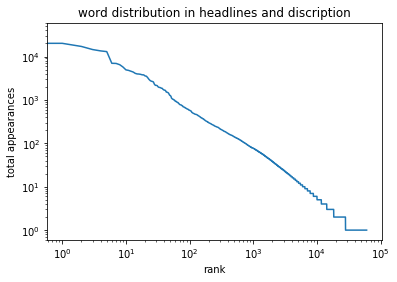

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [130]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [131]:
def get_idx(vocab, vocabcount):
    
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos

    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [132]:
#print("vocab", vocab)

word2idx, idx2word = get_idx(vocab, vocabcount)
# print("word2idx", word2idx)
#print("idx2word", idx2word)

# Word Embedding

## read GloVe

In [133]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os, urllib
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join('./')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    #urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', path)
    !unzip {path}

In [134]:
glove_n_symbols = !wc -l {glove_name}
print(glove_n_symbols)
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

['  400000 ./glove.6B.100d.txt']


400000

In [135]:
import numpy as np

glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        
        glove_embedding_weights[i,:] = [float(x) for x in l[1:]]
        i += 1
glove_embedding_weights *= globale_scale

In [136]:
glove_embedding_weights.std()

0.04081572760019029

In [137]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [138]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
print(len(idx2word), vocab_size)

for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
60384 40000
number of tokens, in small vocab, found in glove and copied to embedding 20079 0.501975


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [139]:
glove_thr = 0.5

In [140]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [143]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 4857


manually check that the worst substitutions we are going to do are good enough

In [144]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.5016688356636366 Piper => Logan
0.5016569384716445 Beardmore => Rolls-Royce
0.5010798919979876 Bennington => Vermont
0.5010642930633238 Gibb => Maurice
0.5010075769478453 Raoul => Philippe
0.5008111253467491 Kokomo => Belleville
0.5007214936690233 Soham => Ashfield
0.5006671308449964 responsibilty => write-down
0.5002791487361785 segmented => fused
0.5002369810238068 Oceanography => Sciences


build a lookup table of index of outside words to index of inside words

In [145]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [146]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

1714

RuntimeError: matplotlib does not support generators as input

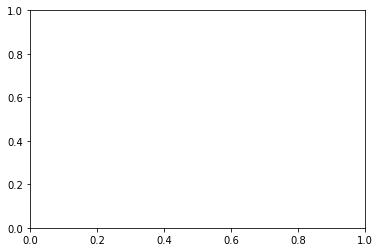

In [147]:
plt.hist(map(len,Y),bins=50);

In [148]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

1714

RuntimeError: matplotlib does not support generators as input

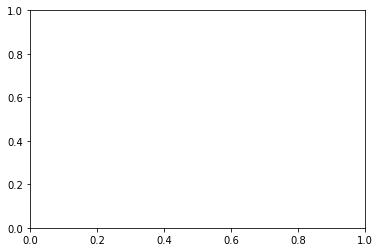

In [149]:
plt.hist(map(len,X),bins=50);

In [152]:
import pickle
with open('%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [154]:
import pickle
with open('%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)